# ACM Digital Library bibliometric analysis of legacy software

![](http://dl.acm.org/images/ACMDL_Logo.jpg)

An incomplete bibliographical inquiry into what the [ACM Digital Library](http://dl.acm.org) has to say about legacy.

Basically two research questions come to mind immidiately. Firstly, have legacy-related publications been on the raise. Secondly, what subtopics can be analyzed?

The first question could afford analysing knowledge being captured in new concept and practices e.g. *refactoring* or *soa*. The second question could afford validation against qualitative methods.

In [341]:
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import numpy as np
import re
%matplotlib inline

## Data loading, sanitization and massage

[Search "legacy" at ACM Digital Library](http://dl.acm.org/results.cfm?query=legacy&filtered=acmPubGroups%2EacmPubGroup=Proceeding&within=owners%2Eowner%3DHOSTED&dte=&bfr=&srt=%5Fscore). Just a simple search, to which the web interface gives 1541 results in mid November 2016. The number of items in the library is ~460000.

A CSV is downloaded from ACM DL, in default sorting order of the library's own idea of relevance... whatever that means for them. BibTeX is also available.

In [474]:
legacybib = pd.read_csv("ACMDL201612108240806.csv")

The available data columns are

In [3]:
legacybib.columns

Index(['type', 'id', 'author', 'editor', 'advisor', 'note', 'title', 'pages',
       'article_no', 'num_pages', 'keywords', 'doi', 'journal', 'issue_date',
       'volume', 'issue_no', 'description', 'month', 'year', 'issn',
       'booktitle', 'acronym', 'edition', 'isbn', 'conf_loc', 'publisher',
       'publisher_loc'],
      dtype='object')

A peek at the topmost data items.

In [453]:
legacybib.head(3)

,type,id,author,editor,advisor,note,title,pages,article_no,num_pages,...,month,year,issn,booktitle,acronym,edition,isbn,conf_loc,publisher,publisher_loc
0,article,505877,Sakib Abdul Mondal and Kingshuk Das Gupta,NaN,NaN,NaN,Choosing a Middleware for Web-integration of a...,50--53,NaN,4,...,May,2000,0163-5948,NaN,NaN,NaN,NaN,NaN,ACM,"New York, NY, USA"
1,article,2487308,Brandon Kyle Phillips and Sherry Ryan and Gin...,NaN,NaN,NaN,Motivating Students to Acquire Mainframe Skills,73--78,NaN,6,...,NaN,2013,NaN,Proceedings of the 2013 Annual Conference on C...,SIGMIS-CPR '13,NaN,978-1-4503-1975-1,"Cincinnati, Ohio, USA",ACM,"New York, NY, USA"
2,article,2048229,Dennis Mancl and Steven D. Fraser and Bill O...,NaN,NaN,NaN,Workshop: Beyond Green-field Software Developm...,321--322,NaN,2,...,NaN,2011,NaN,Proceedings of the ACM International Conferenc...,OOPSLA '11,NaN,978-1-4503-0942-4,"Portland, Oregon, USA",ACM,"New York, NY, USA"


Does the `id` field uniquely identify items on the search list? If so, using it as index could be a good idea.

In [484]:
assert 0, sum(legacybib.id.duplicated())

AssertionError: 77

In [489]:
legacybib[legacybib.id.duplicated(keep=False)].head(2 * 2)

,type,id,author,editor,advisor,note,title,pages,article_no,num_pages,...,month,year,issn,booktitle,acronym,edition,isbn,conf_loc,publisher,publisher_loc
21,article,1352602,Carsten Weinhold and Hermann H&#228;rtig,NaN,NaN,NaN,VPFS: Building a Virtual Private File System w...,81--93,NaN,13,...,April,2008,0163-5980,NaN,NaN,NaN,NaN,NaN,ACM,"New York, NY, USA"
22,article,1352602,Carsten Weinhold and Hermann H&#228;rtig,NaN,NaN,NaN,VPFS: Building a Virtual Private File System w...,81--93,NaN,13,...,NaN,2008,NaN,Proceedings of the 3rd ACM SIGOPS/EuroSys Euro...,Eurosys '08,NaN,978-1-60558-013-5,"Glasgow, Scotland UK",ACM,"New York, NY, USA"
35,article,1402988,Maxim Podlesny and Sergey Gorinsky,NaN,NaN,NaN,Rd Network Services: Differentiation Through P...,255--266,NaN,12,...,August,2008,0146-4833,NaN,NaN,NaN,NaN,NaN,ACM,"New York, NY, USA"
36,article,1402988,Maxim Podlesny and Sergey Gorinsky,NaN,NaN,NaN,Rd Network Services: Differentiation Through P...,255--266,NaN,12,...,NaN,2008,NaN,Proceedings of the ACM SIGCOMM 2008 Conference...,SIGCOMM '08,NaN,978-1-60558-175-0,"Seattle, WA, USA",ACM,"New York, NY, USA"


Ok apparently it is used for deduplication. Who knows why are the items twice in the downloaded list.

What datatypes did Pandas infer from the CSV

In [6]:
legacybib.dtypes

type              object
id                object
author            object
editor            object
advisor          float64
note              object
title             object
pages             object
article_no       float64
num_pages        float64
keywords          object
doi               object
journal           object
issue_date        object
volume            object
issue_no          object
description       object
month             object
year             float64
issn              object
booktitle         object
acronym           object
edition          float64
isbn              object
conf_loc          object
publisher         object
publisher_loc     object
dtype: object

Massage the keywords to be lists.

In [475]:
legacybib.keywords.fillna('', inplace=True)
legacybib.keywords = legacybib.keywords.map(lambda l: [k.lower().strip() for k in l.split(',')])

Are any items missing the year?

In [478]:
legacybib[legacybib.year.isnull()].year

116   NaN
561   NaN
Name: year, dtype: float64

### Complementary data

To contextualize the *legacy* search results, get the number of total publications in ACM per year. 

These were semimanually extracted from the ACM DL search results listing DOM, with the following Javascript

```javascript
acmYearly = {};
theChartData.labels.forEach(function(y) {acmYearly[y] = theChartData.datasets[0].data[theChartData.labels.indexOf(y)]});
console.log(acmYearly);
```

In [9]:
acmPerYearData = { 1951: 43, 1952: 77, 1953: 34, 1954: 71, 1955: 72, 1956: 162, 1957: 144, 1958: 234, 1959: 335,
              1960: 302, 1961: 521, 1962: 519, 1963: 451, 1964: 537, 1965: 561, 1966: 633, 1967: 754, 1968: 669, 1969: 907,
              1970: 800, 1971: 1103, 1972: 1304, 1973: 1704, 1974: 1698, 1975: 1707, 1976: 2086, 1977: 1943, 1978: 2235, 1979: 1687,
              1980: 2152, 1981: 2241, 1982: 2578, 1983: 2485, 1984: 2531, 1985: 2608, 1986: 3143, 1987: 3059, 1988: 3827, 1989: 4155,
              1990: 4313, 1991: 4551, 1992: 5019, 1993: 5107, 1994: 5939, 1995: 6179, 1996: 6858, 1997: 7181, 1998: 8003, 1999: 7628,
              2000: 9348, 2001: 8691, 2002: 10965, 2003: 11624, 2004: 14493, 2005: 16715, 2006: 19222, 2007: 19865, 2008: 21631, 2009: 23827,
              2010: 27039, 2011: 25985, 2012: 27737, 2013: 25832, 2014: 26928, 2015: 27131, 2016: 25557, 2017: 39}
acmPerYear = pd.Series(acmPerYearData)

### Data overview

Let's check how many percent all the 1541 search results given by the website search list. Would be great if this was 100%.

In [10]:
round(len(legacybib) / 1541 * 100, 2)

69.89

With the above peek at the ID field, how many unique items did we receive in the download?

In [498]:
len(legacybib.id.unique())

1000

Ok capped at 1000 I guess, which brings the percentage of the website search results available to us down to

In [497]:
round(len(legacybib.id.unique()) / 1541 * 100, 2)

64.89

## Data exploration

Fraction of published items per year which ACM identifies as relevant for legacy search.

### Histogram of publication years

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


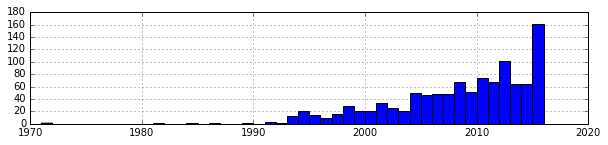

In [500]:
legacybib.year.hist(bins=legacybib.year.max() - legacybib.year.min(), figsize=(10,2))

What about the ACM Digital Library total, what does it's profile look like over time?

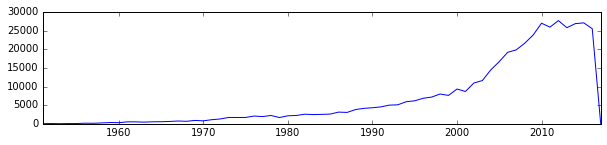

In [12]:
acmPerYear.plot(figsize=(10, 2))

Similar overall shape, which isn't a surprise. Overlay, with arbitrary scaling of 300.

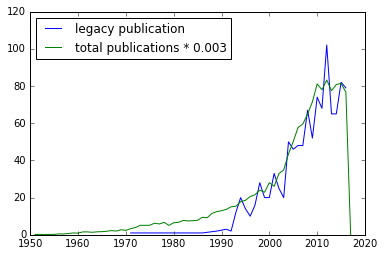

In [505]:
#plt.hist(legacybib.year.dropna(), label="Year histogram")
plt.plot(legacybib.year.groupby(legacybib.year).count(), label='legacy publication')
plt.plot(acmPerYear * 0.003, label="total publications * 0.003")
plt.legend()
plt.legend(loc='best')

Right, so they seem to have somewhat similar shape. Legacy as a concept was lagging overall ACM DL, until it caught by increasing growth during 1990s.

What about the ratio of this subset of the whole ACM DL? Has it increased or decreased over time? Ie. has the proportion of publications about legacy changed?

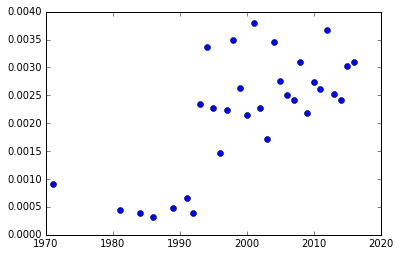

In [437]:
plt.plot(pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear), 'o')

All the pre-1990 publications are:

In [455]:
legacybib[legacybib.year <= 1990][["year", "title"]].sort_values("year")

,year,title
101,1971,The Legacy of MATHLAB 68
716,1981,V-Compiler: A Next-generation Tool for Micropr...
92,1984,Redocumentation: Addressing the Maintenance Le...
105,1986,Ada: A Life and Legacy: Dorothy Stein Book Review
329,1989,Saving Legacy with Objects
330,1989,Saving Legacy with Objects


And over 1000 publications after 1990, until 2016. First 10 of which are

In [456]:
legacybib[legacybib.year > 1990][["year", "title"]].sort_values("year").head(10)

,year,title
475,1991,On the Semantic Equivalence of Heterogeneous R...
378,1991,A Software Reverse Engineering Experience
665,1991,From Under the Rubble: Computing and the Resus...
154,1992,Assessing Design-quality Metrics on Legacy Sof...
984,1992,Experiences in Program Understanding
487,1993,Engineering an SQL Gateway to IMS
335,1993,Re-engineering Design Trade-offs in a Legacy C...
314,1993,The Development of a Partial Design Recovery E...
309,1993,Issues and Approaches for Migration/Cohabitati...
308,1993,Issues and Approaches for Migration/Cohabitati...


Did something happen around 1990s, as the fraction of publications related to legacy started increasing? Let's plot a global linear regression model, as well as separate linear regression models before and after 1990.

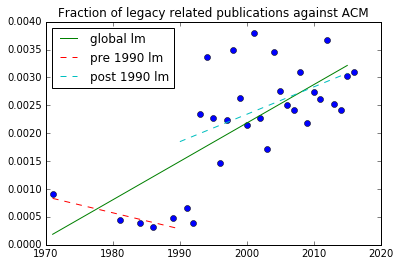

In [446]:
pre1990range = np.arange(legacybib.year.min(), 1991)
post1990range = np.arange(1990, legacybib.year.max())

# Linear regression models
# note the use of np.polyfit
propLm = np.polyfit(pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear).dropna().index, pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear).dropna(), 1)
pre1990 = np.polyfit(pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear)[pre1990range].dropna().index, pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear)[pre1990range].dropna(), 1)
post1990 = np.polyfit(pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear)[post1990range].dropna().index, pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear)[post1990range].dropna(), 1)

# Plot the fractions of legacy vs. all publications, the models, and a legend
plt.plot(pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear), 'o')
plt.plot(np.arange(legacybib.year.min(), legacybib.year.max()), np.poly1d(propLm)(np.arange(legacybib.year.min(), legacybib.year.max())), label="global lm")
plt.plot(pre1990range, np.poly1d(pre1990)(pre1990range), linestyle="dashed", label="pre 1990 lm")
plt.plot(post1990range, np.poly1d(post1990)(post1990range), linestyle="dashed", label="post 1990 lm")
plt.title("Fraction of legacy related publications against ACM")
plt.legend(loc="best")

Statistical validation of the above would be good, of course, to check against randomness.

## A histogram of keywords

The keywords are interesting. All keywords in this dataset are already related to legacy one way or the other, since the data under inspection here is a subset of the total ACM Digital Library.

Keywords of course live a life of their own, and I guess there increase in number forever.

Which keywords are popular?

In [102]:
# this could be a pandas.Series instead of dict
keywordhist = {}
for kws in legacybib.keywords:
    for k in kws:
        if k in keywordhist:
            keywordhist[k] = keywordhist[k] + 1
        else:
            keywordhist[k] = 1

Total number of unique keywords:

In [16]:
len(keywordhist)

2285

Of which occur in 10 or more items in the subset

In [17]:
[(k, keywordhist[k]) for k in sorted(keywordhist, key=keywordhist.get, reverse=True) if keywordhist[k] >= 10]

[('', 376),
 ('legacy systems', 27),
 ('reverse engineering', 24),
 ('legacy software', 19),
 ('reengineering', 18),
 ('refactoring', 17),
 ('java', 16),
 ('software evolution', 14),
 ('migration', 14),
 ('software architecture', 12),
 ('cloud computing', 12),
 ('security', 12),
 ('legacy', 11),
 ('legacy system', 10),
 ('middleware', 10),
 ('interoperability', 10),
 ('design', 10),
 ('architecture', 10)]

and further those that occur in 3-10 items

In [18]:
[(k, keywordhist[k]) for k in sorted(keywordhist, key=keywordhist.get, reverse=True) if keywordhist[k] < 10 and keywordhist[k] >= 3]

[('soa', 9),
 ('performance', 9),
 ('software engineering', 9),
 ('c', 9),
 ('reuse', 8),
 ('legacy code', 8),
 ('multimedia', 7),
 ('virtualization', 7),
 ('software product lines', 7),
 ('code generation', 7),
 ('transactional memory', 7),
 ('fortran', 7),
 ('measurement', 7),
 ('c++', 7),
 ('corba', 7),
 ('trusted computing', 7),
 ('parallelism', 7),
 ('static analysis', 6),
 ('integration', 6),
 ('personalization', 6),
 ('usability', 6),
 ('openflow', 6),
 ('sdn', 6),
 ('digital legacy', 5),
 ('metadata', 5),
 ('memory', 5),
 ('user experience', 5),
 ('type inference', 5),
 ('semantic web', 5),
 ('android', 5),
 ('eclipse', 5),
 ('death', 5),
 ('evolution', 5),
 ('privacy', 5),
 ('patterns', 5),
 ('reflection', 5),
 ('storage', 5),
 ('service oriented architecture', 4),
 ('gpu', 4),
 ('testing', 4),
 ('case study', 4),
 ('open source', 4),
 ('object-oriented', 4),
 ('embedded systems', 4),
 ('machine learning', 4),
 ('late launch', 4),
 ('web applications', 4),
 ('architecture reco

Of the remainder, number of keywords which appear on only two items

In [19]:
len([k for k in keywordhist if keywordhist[k] == 2])

305

and only on one item

In [20]:
len([k for k in keywordhist if keywordhist[k] == 1])

1802

## Keywords with 'legacy' in them

In [22]:
sorted([(k, keywordhist[k]) for k in keywordhist if re.match("legacy", k)], key=lambda k: k[1], reverse=True)

[('legacy systems', 27),
 ('legacy software', 19),
 ('legacy', 11),
 ('legacy system', 10),
 ('legacy code', 8),
 ('legacy modernization', 3),
 ('legacy integration', 3),
 ('legacy programs', 2),
 ('legacy traffic', 2),
 ('legacy reuse', 2),
 ('legacy infrastructure', 2),
 ('legacy data', 2),
 ('legacy applications', 1),
 ('legacy models', 1),
 ('legacy support', 1),
 ('legacy file formats', 1),
 ('legacy contact', 1),
 ('legacy study', 1),
 ('legacy information systems', 1),
 ('legacy c program parallelization', 1),
 ('legacy data conversion', 1),
 ('legacy document conversion', 1),
 ('legacy system analysis', 1),
 ('legacy migration', 1),
 ('legacy bias', 1),
 ('legacy networks', 1),
 ('legacy code wrapping', 1),
 ('legacy technology', 1),
 ('legacy software product lines', 1),
 ('legacy devices', 1),
 ('legacy application', 1),
 ('legacy system integration', 1),
 ('legacy systems analysis', 1),
 ('legacy system maintenance', 1),
 ('legacy assets mining', 1),
 ('legacy database', 1)]

## Network analysis of keywords

Keywords are a comma separated list in `keywords`, let's pull all of them out to a graph.

An analysis of which keywords are actually plentiful, their temporal distibution etc. centrality metrics, subgraph overlap etc. would be great.

In [23]:
keywordg = nx.Graph()
legacybib.keywords.map(lambda item: keywordg.add_edges_from([p for p in itertools.permutations(item, 2)]), na_action='ignore')
print("Number of components", len([comp for comp in nx.connected_components(keywordg)]))
print("Largest ten components sizes", sorted([len(comp) for comp in nx.connected_components(keywordg)], reverse=True)[:10])

Number of components 156
Largest ten components sizes [1625, 13, 11, 11, 11, 10, 9, 9, 9, 9]


So there is one dominant component, and 150 small ones. It's best to explore them interactively with Gephi.

In [795]:
nx.write_gexf(keywordg, "keywordg.gexf")

Degree distribution of the keyword graph, ie. are there a few nodes which have huge degree and then a large number of nodes with smaller number of connections, like a power network. Additionally, let's see where the keywords with the work *legacy* in them are placed, by indicating them with green vertical lines. In the left diagram below, hubs are towards the right.

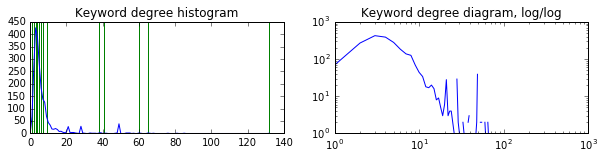

In [159]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(10, 2)
ax1.set_title("Keyword degree histogram")
ax1.plot(nx.degree_histogram(keywordg))
ax1.vlines([keywordg.degree(l) for l in keywordg if re.match('legacy', l)], ax1.get_ylim()[0], ax1.get_ylim()[1], colors='green')
ax2.set_title("Keyword degree diagram, log/log")
ax2.loglog(nx.degree_histogram(keywordg))

Eyeballing the above, most of the legacy keywords are where the mass of the distribution is, ie. at low degrees. One of the *legacy* nodes is a top hub, and there are some in the mid-ranges.

The top 3 keywords with the highest degree, ie. towards the right of the above graph are:

In [160]:
keywordgDegrees = pd.Series(keywordg.degree()).sort_values(ascending=False)
keywordgDegrees.head(3)

legacy systems         132
architecture            85
reverse engineering     81
dtype: int64

Let's plot the top hub out.

In [209]:
def plotNeighborhood(graph, ego, color = "green", includeEgo = False):
    from math import sqrt
    """
    Plot neighbourhood of keyword in graph, after possibly removing the ego.
    
    graph : networkx.Graph-like graph
        The graph to get the neighbourhood from
    ego : node in graph
        The node whose neighbourhood to plot
    color : string
        Name of the color to use for plotting
    includeEgo : bool
        Include the ego node
        
    The function defaults to removing the ego node, because by definition
    it is connected to each of the nodes in the subgraph. With the ego
    removed, the result basically tells how the neighbours are connected
    with one another.
    """
    plt.rcParams["figure.figsize"] = (10, 10)
    subgraph = nx.Graph()
    if includeEgo:
        subgraph = graph.subgraph(graph.neighbors(ego) + [ego])
    else:
        subgraph = graph.subgraph(graph.neighbors(ego))
    plt.title("Neighbourhood of " + ego + " (" + str(len(subgraph)) + ")")
    plt.axis('off')
    pos = nx.spring_layout(subgraph, k = 1/sqrt(len(subgraph) * 2))
    nx.draw_networkx(subgraph,
                     pos = pos,
                     font_size = 9,
                     node_color = color,
                     alpha = 0.8,
                     edge_color = "light" + color)
    plt.show()

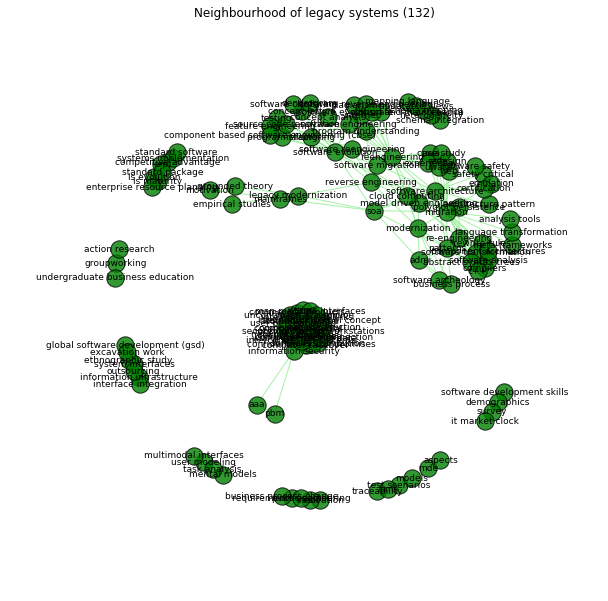

In [207]:
plotGraph(keywordg, "legacy systems")

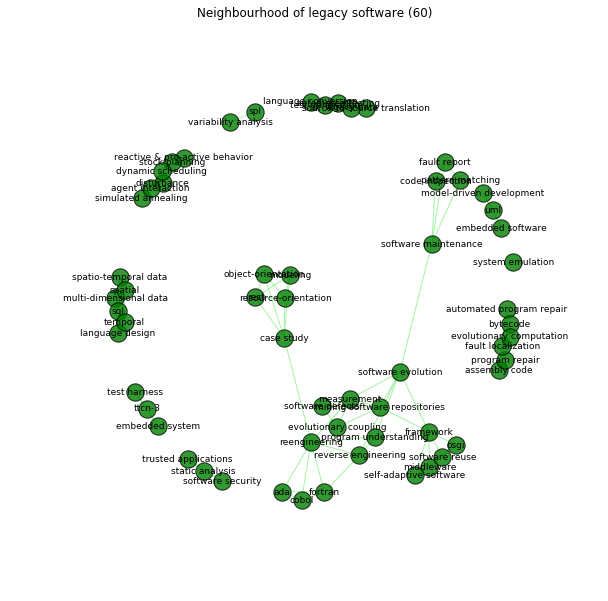

In [792]:
plotGraph(keywordg, "legacy software")